In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

sns.set(
    rc = {
        'pdf.fonttype': 42, # avoid type 3 fonts on PDF figures
        'ps.fonttype': 42,
    }, font_scale=1.65 # increase font size
)

# improve rendering of plots on retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../datapackage/quiho/results.csv')

# Preprocessing

In [3]:
df.columns

Index(['giturl', 'commit', 'user', 'timestamp', 'benchmark', 'machine',
       'repetition', 'test', 'result'],
      dtype='object')

In [4]:
df.benchmark.unique()

array(['stressng', 'ssca', 'hpccg', 'scikit-learn', 'redisbench', 'comd',
       'lulesh', 'miniaero', 'miniamr', 'minife', 'fio', 'zlog', 'stream',
       'mysqlslap-mariadb-10.3.2', 'mysqlslap-mariadb-5.5.58', 'mysqlslap'], dtype=object)

In [5]:
df.test.unique()

array(['af-alg', 'atomic', 'bigheap', 'brk', 'bsearch', 'cache', 'cpu',
       'crypt', 'full', 'heapsort', 'hsearch', 'icache', 'lockbus',
       'longjmp', 'lsearch', 'malloc', 'matrix', 'memcpy', 'mincore',
       'mmap', 'mremap', 'msync', 'nop', nan, 'numa', 'oom-pipe', 'opcode',
       'qsort', 'remap', 'resources', 'rmap', 'shm', 'shm-sysv', 'stack',
       'stackmmap', 'str', 'stream', 'tsearch', 'vecmath', 'vm', 'vm-rw',
       'vm-splice', 'zero', 'ssca', 'hpccg', 'scikit-learn', 'SET', 'GET',
       'LPUSH', 'LPOP', 'comd', 'lulesh', 'miniaero', 'miniamr', 'minife',
       'randread-fiofile-128k-seq', 'randwrite-fiofile-128k-seq',
       'read-fiofile-128k-seq', 'rw-fiofile-128k-seq',
       'write-fiofile-128k-seq', 'randread-fiofile-4096k-seq',
       'randwrite-fiofile-4096k-seq', 'read-fiofile-4096k-seq',
       'rw-fiofile-4096k-seq', 'write-fiofile-4096k-seq',
       'randread-fiofile-4k-seq', 'randwrite-fiofile-4k-seq',
       'read-fiofile-4k-seq', 'rw-fiofile-4k-seq

In [6]:
df.machine.unique()

array(['c220g1.quiho.schedock-PG0.wisc.cloudlab.us',
       'c220g2.quiho.schedock-PG0.wisc.cloudlab.us',
       'c6220.quiho.schedock-PG0.apt.emulab.net',
       'c6320.quiho.schedock-PG0.clemson.cloudlab.us',
       'c8220.quiho.schedock-PG0.clemson.cloudlab.us',
       'd2100.quiho.Schedock.emulab.net', 'd430.quiho.Schedock.emulab.net',
       'd530.quiho.Schedock.emulab.net', 'd710.quiho.Schedock.emulab.net',
       'd820.quiho.Schedock.emulab.net',
       'dl360.quiho.emulab-net.utahddc.geniracks.net',
       'dwill.soe.ucsc.edu', 'issdm-0',
       'm510.quiho.schedock-PG0.utah.cloudlab.us',
       'pc2400.quiho.emulab-net.uky.emulab.net',
       'pc3000.quiho.Schedock.emulab.net',
       'pc3300.quiho.emulab-net.uky.emulab.net',
       'pc3400.quiho.emulab-net.uky.emulab.net',
       'pc3500.quiho.emulab-net.uky.emulab.net',
       'r320.quiho.schedock-PG0.apt.emulab.net', 'scruffy.soe.ucsc.edu',
       'issdm-41', 'r720.quiho.schedock-PG0.apt.emulab.net',
       'c220g1.quiho-iv

In [7]:
df.sample(5).T

,6693,26943,27368,20960,23707
giturl,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper
commit,d46d579,d46d579,d46d579,d46d579,d46d579
user,ivo,ivo,ivo,ivo,ivo
timestamp,1497506400000,1499724178000,1499724178000,1499724178000,1499724178000
benchmark,stressng,stream,stream,stressng,stream
machine,c8220.quiho.schedock-PG0.clemson.cloudlab.us,pc3500.quiho2.emulab-net.uky.emulab.net,r720.quiho2.schedock-PG0.apt.emulab.net,pc3400.quiho2.emulab-net.uky.emulab.net,c6220.quiho2.schedock-PG0.apt.emulab.net
repetition,1,4,3,1,5
test,opcode,add-14,triad-8,mincore,add-4
result,1097.69,311.5,1764.7,25519.5,3573.3


In [8]:
# treat every repetition as a new data point
df['machine_id'] = df.apply(lambda x: x['machine'] + '-' + str(x['repetition']) + '-' + str(x['timestamp']), axis=1) 

In [9]:
# the 'null' stressor is loaded as a null string, so let's fix it
df['test'] = df['test'].apply(lambda x: 'null' if pd.isnull(x) else x)

len(df)

27677

In [10]:
# better naming for redis tests
df['test'] = df.apply(lambda x: 'redis-' + x['test'].lower() if x['benchmark'] == 'redisbench' else x['test'], axis=1)

In [11]:
# rename mariadb tests
df['test'] = df.apply(lambda x: 'mariadb-{}-{}'.format(x['benchmark'].split('-')[2], x['test']) if 'mysqlslap-' in x['benchmark'] else x['test'], axis=1)

In [12]:
# what we use for feature vectors
df.query('benchmark == "stressng"')['test'].unique()

array(['af-alg', 'atomic', 'bigheap', 'brk', 'bsearch', 'cache', 'cpu',
       'crypt', 'full', 'heapsort', 'hsearch', 'icache', 'lockbus',
       'longjmp', 'lsearch', 'malloc', 'matrix', 'memcpy', 'mincore',
       'mmap', 'mremap', 'msync', 'nop', 'null', 'numa', 'oom-pipe',
       'opcode', 'qsort', 'remap', 'resources', 'rmap', 'shm', 'shm-sysv',
       'stack', 'stackmmap', 'str', 'stream', 'tsearch', 'vecmath', 'vm',
       'vm-rw', 'vm-splice', 'zero'], dtype=object)

In [13]:
# what we can use to build models (apps whose performance we can learn)
df.query('benchmark != "stressng"')['test'].unique()

array(['ssca', 'hpccg', 'scikit-learn', 'redis-set', 'redis-get',
       'redis-lpush', 'redis-lpop', 'comd', 'lulesh', 'miniaero',
       'miniamr', 'minife', 'randread-fiofile-128k-seq',
       'randwrite-fiofile-128k-seq', 'read-fiofile-128k-seq',
       'rw-fiofile-128k-seq', 'write-fiofile-128k-seq',
       'randread-fiofile-4096k-seq', 'randwrite-fiofile-4096k-seq',
       'read-fiofile-4096k-seq', 'rw-fiofile-4096k-seq',
       'write-fiofile-4096k-seq', 'randread-fiofile-4k-seq',
       'randwrite-fiofile-4k-seq', 'read-fiofile-4k-seq',
       'rw-fiofile-4k-seq', 'write-fiofile-4k-seq', 'zlog', 'copy-1',
       'scale-1', 'add-1', 'triad-1', 'copy-10', 'scale-10', 'add-10',
       'triad-10', 'copy-12', 'scale-12', 'add-12', 'triad-12', 'copy-14',
       'scale-14', 'add-14', 'triad-14', 'copy-16', 'scale-16', 'add-16',
       'triad-16', 'copy-18', 'scale-18', 'add-18', 'triad-18', 'copy-2',
       'scale-2', 'add-2', 'triad-2', 'copy-20', 'scale-20', 'add-20',
       'triad-

# Visualize Variability

Let's visualize the variability across these two datasets (training vectors and learneable variable). We will first define a helper function for obtaining the transpose of the dataframe. This turns stressors and applications into columns.

In [14]:
# obtain a list with the name of all the stressors
stressors = list(df.query('benchmark == "stressng"')['test'].unique())

def get_features(in_df):
    # first we transpose (pivot) the matrix so features are columns 
    dff = in_df.pivot_table(index=["machine_id","test"], values=['result'], fill_value=0, aggfunc=np.mean).unstack().reset_index()

    # then we flatten the index and rename the first column
    cols = dff.columns.get_level_values(1).values
    cols[0] = 'machine_id'
    dff.columns = cols

    # cleanup the remaining NaN, Inf values for stressors
    for s in stressors:
        dff = dff[dff[s].notnull()]
        
    return dff

Show executions of the data generation phase (every timestamp is a new execution)

In [15]:
df['timestamp'].unique()

array([   1512873230, 1497974400000, 1497506400000, 1498013938000,
       1499030038000, 1499724178000])

To ease the visualization of the variability, we'll select just one execution. We'll use the entire dataset later

In [16]:
subdf = df.query('timestamp == {}'.format(df['timestamp'].unique()[0]))

In [17]:
# all stressor columns should NOT be NaN. App result
# can be NaN since we don't run all the apps always,
# but we do run stressng always.
data = get_features(subdf)
data

,machine_id,af-alg,atomic,bigheap,brk,bsearch,cache,cpu,crypt,full,...,stack,stackmmap,str,stream,tsearch,vecmath,vm,vm-rw,vm-splice,zero
0,c220g1.quiho.schedock-PG0.wisc.cloudlab.us-1-1...,7553.476964,699767.049846,35210.011062,684735.448826,370.313794,3.399998,269.833322,157.831009,280837.319050,...,0.0,5.397300,20955.323904,14.517656,17.756406,995.086762,34697.775954,117.267599,588011.993310,701306.704518
1,c220g1.quiho.schedock-PG0.wisc.cloudlab.us-2-1...,7781.799579,691836.590695,33999.916024,682041.349398,372.682371,3.600002,264.553771,161.523973,296257.696313,...,0.0,5.598201,20968.719984,14.652581,16.786215,973.285311,34695.541978,116.854283,586556.818768,718532.440164
2,c220g1.quiho.schedock-PG0.wisc.cloudlab.us-3-1...,7654.659131,712211.530050,37636.623619,667473.993735,372.613969,3.599991,265.507952,162.699643,297467.966664,...,0.0,5.597200,20564.082368,14.447820,16.270731,996.230264,34701.876453,118.142747,598837.814568,715842.974215
3,c220g2.quiho.schedock-PG0.wisc.cloudlab.us-1-1...,7576.272619,698310.778376,36081.440609,690984.701922,372.592218,3.799984,276.980486,159.492281,309012.419755,...,0.0,5.696730,21182.455044,14.314298,18.046983,970.776508,34703.410879,117.338797,606701.865304,693842.364086
4,c220g2.quiho.schedock-PG0.wisc.cloudlab.us-2-1...,7531.099951,684369.001130,34759.942609,694266.818332,358.423048,3.899979,263.903257,160.624668,273255.221193,...,0.0,5.497121,20650.348687,14.811781,16.863218,996.597006,34701.328948,117.013256,603501.240285,724968.391488
5,c220g2.quiho.schedock-PG0.wisc.cloudlab.us-3-1...,7835.013335,687027.076900,36934.283293,701044.051951,372.575226,3.899998,265.577189,152.935049,304679.107067,...,0.0,5.598216,20677.093173,14.201360,16.670087,1004.533012,34702.745229,119.048118,594216.428401,692966.676487
6,c6220.quiho.schedock-PG0.apt.emulab.net-1-1512...,11119.491584,566815.710868,11945.623346,279372.101247,320.867621,3.799998,201.868509,105.625015,194135.223026,...,0.0,173.853804,16261.965942,10.608002,15.068510,877.780328,31415.442044,128.789904,512002.676568,586474.011377
7,c6220.quiho.schedock-PG0.apt.emulab.net-2-1512...,11023.967364,561608.733555,10985.161850,221384.126633,315.068892,4.100000,197.601607,104.149479,153795.899679,...,0.0,138.614289,16346.893148,11.863663,15.068529,877.302445,31390.298496,147.249537,518529.360715,588227.902445
8,c6220.quiho.schedock-PG0.apt.emulab.net-3-1512...,10939.796147,560050.729023,10511.676989,239887.563793,317.727533,3.900000,198.788331,105.544738,190965.732698,...,0.0,174.942951,16296.135208,12.694215,14.796761,865.246798,31405.162042,142.679413,513604.620434,593552.285896
9,c6320.quiho.schedock-PG0.clemson.cloudlab.us-1...,7734.249783,452897.790114,28385.389288,508394.555207,251.252341,3.100000,175.847631,106.680136,149373.322669,...,0.0,3.797076,12709.650908,6.002785,11.434522,713.082115,31202.329376,103.114643,412572.826266,429844.312046


Now we'll look at the variability of stressors performance across machines



In [18]:
sns.set(rc = {'figure.figsize': (12.0, 5.0)}, font_scale=1.65)

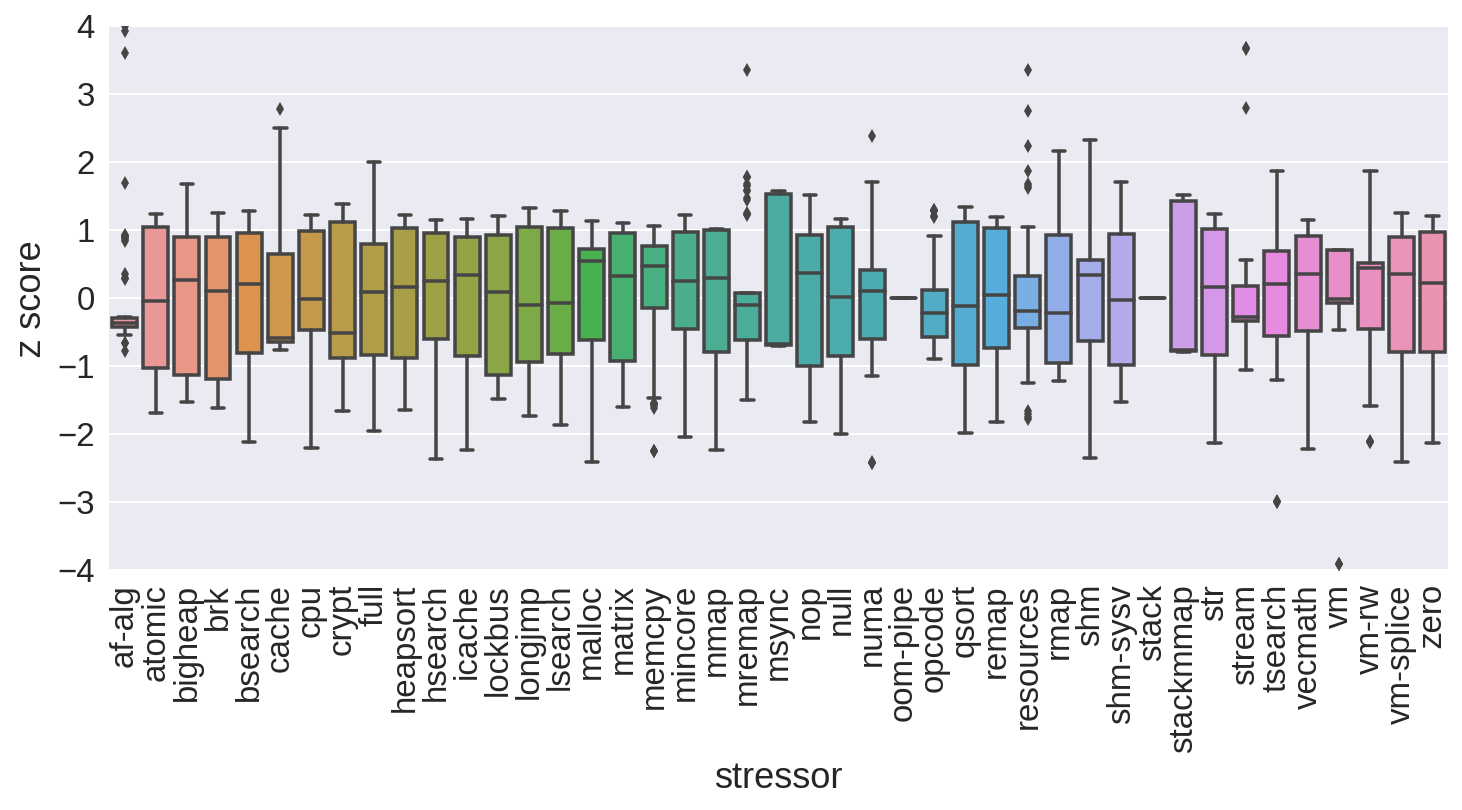

In [19]:
rs = np.random.RandomState(1)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(data[stressors])

dff = pd.DataFrame(z_data, columns=stressors)

sns.boxplot(data=dff)
_ = plt.xticks(rotation=90)
plt.ylim(-4,4)
plt.ylabel('z score')
plt.xlabel('stressor')
plt.savefig('figures/stressng_variability.pdf', dpi=300, bbox_inches='tight')

We can also see the variability for some of the applications we are trying to learn

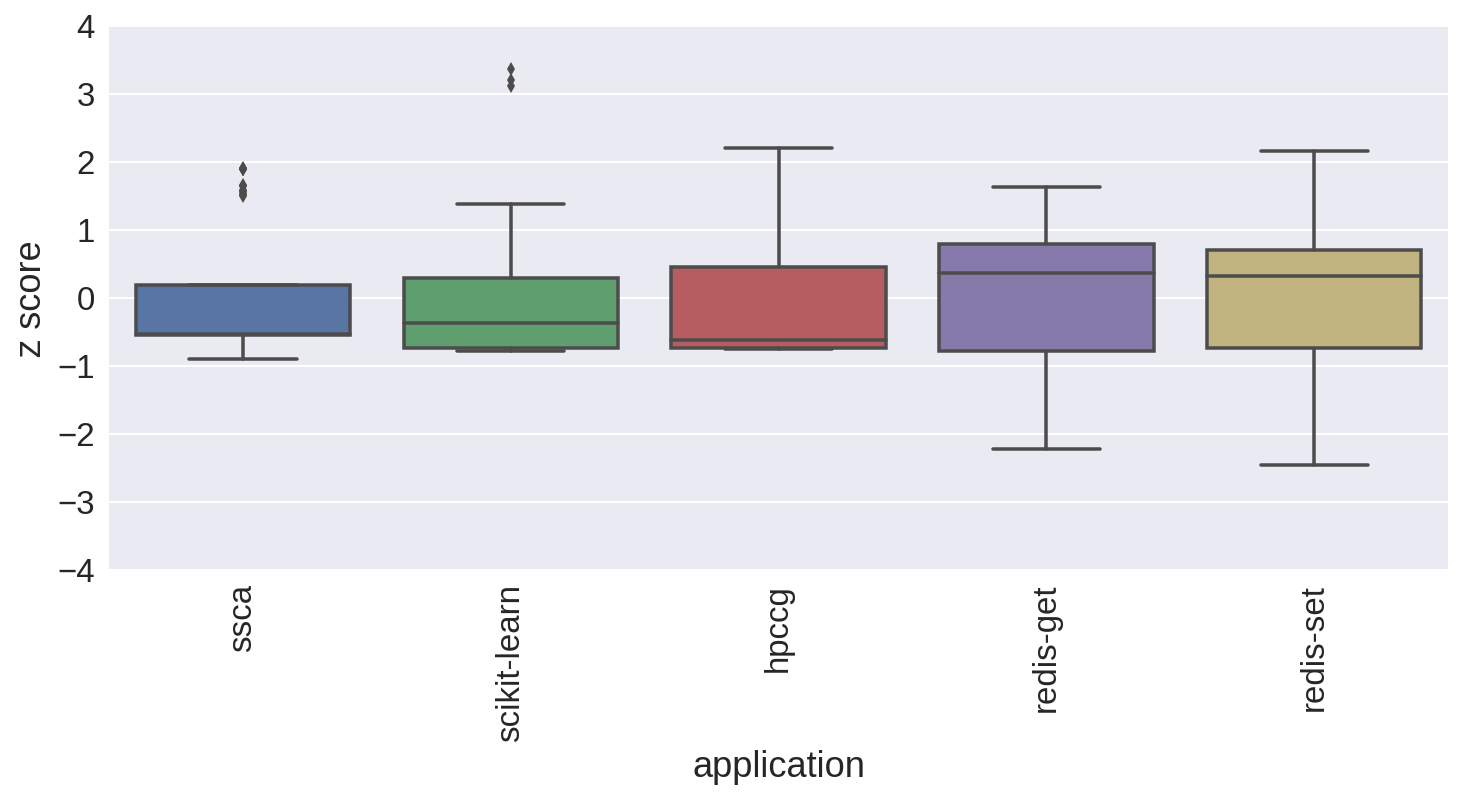

In [20]:
apps_subset = ['ssca', 'scikit-learn', 'hpccg', 'redis-get', 'redis-set']

rs = np.random.RandomState(1)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(data[apps_subset].dropna())

dff = pd.DataFrame(z_data, columns=apps_subset)

sns.boxplot(data=dff)
_ = plt.xticks(rotation=90)
plt.ylim(-4,4)
plt.ylabel('z score')
plt.xlabel('application')
plt.savefig('figures/apps_variability.pdf', dpi=300, bbox_inches='tight')

In [21]:
# let's define a function to obtain and plot pearson correlation coefficients
def plot_corrmatrix(dataf):
    corrmatrix = dataf.corr()
    mask = np.zeros_like(corrmatrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corrmatrix, mask=mask,
                xticklabels=corrmatrix.columns.values,
                yticklabels=corrmatrix.columns.values)
    return corrmatrix

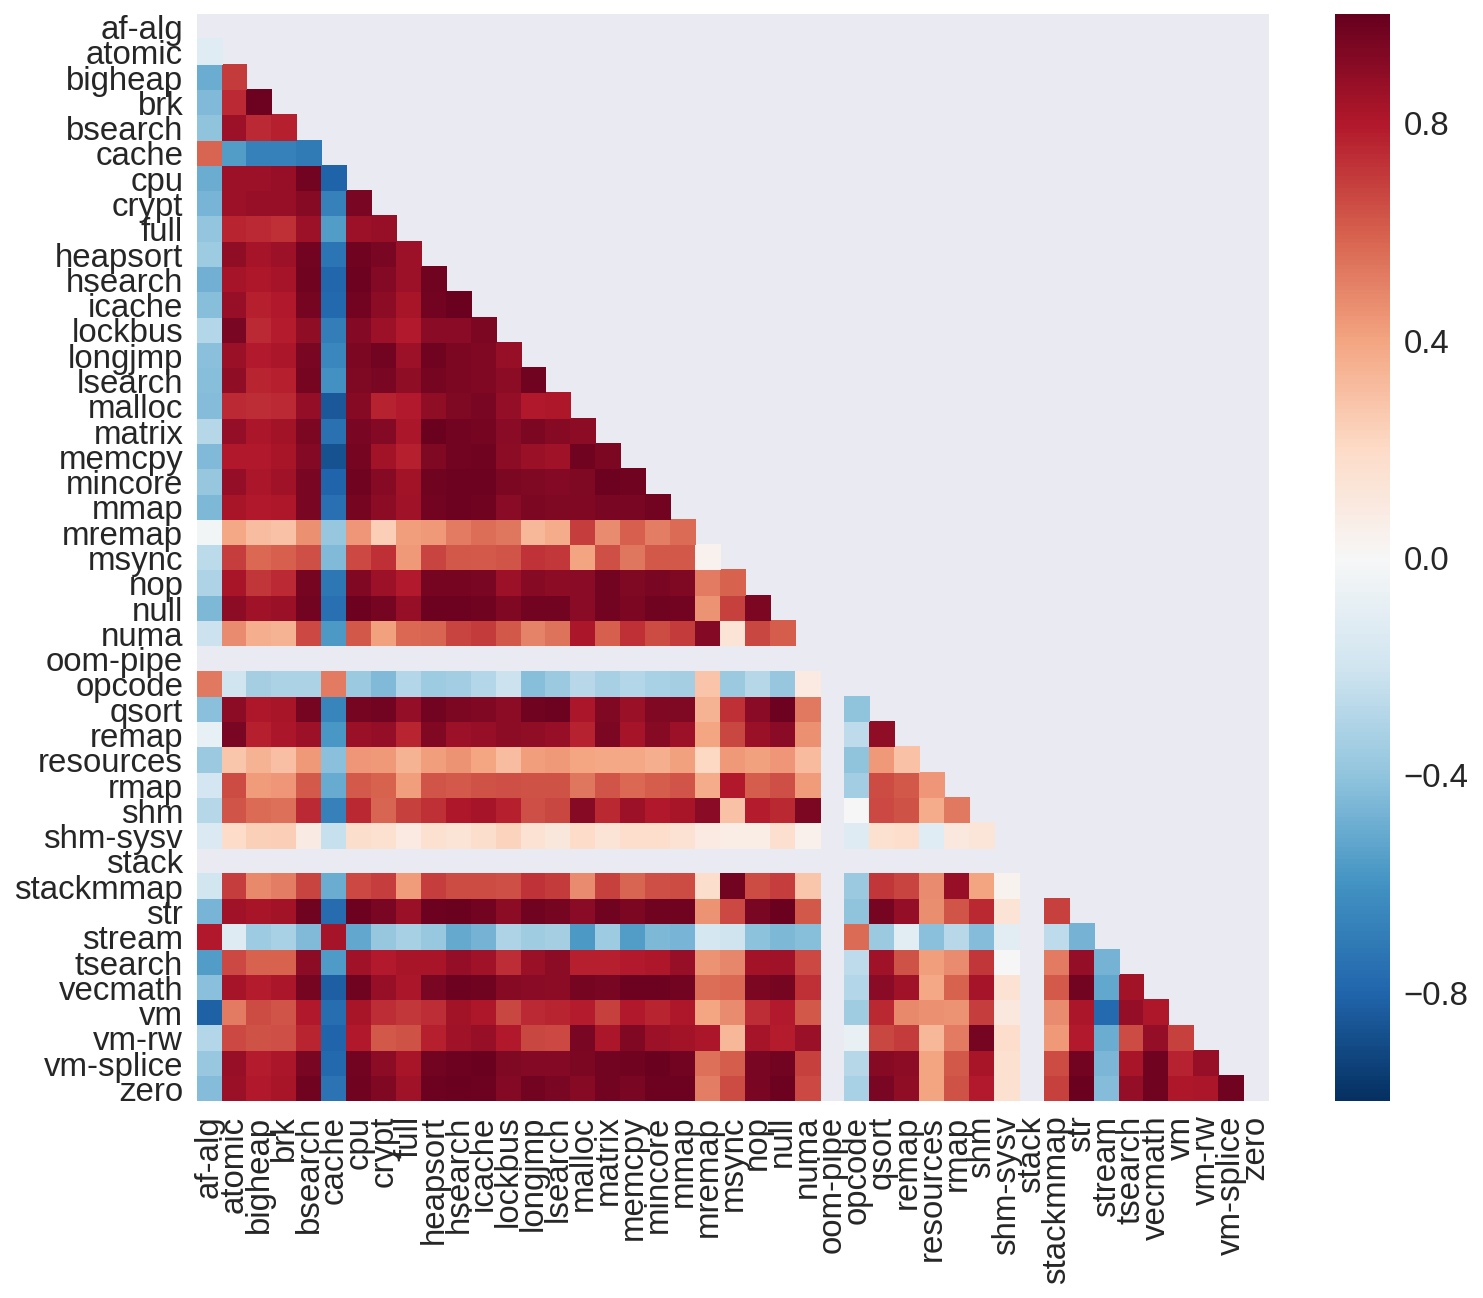

In [22]:
sns.set(rc = {'figure.figsize': (12.0, 10.0)}, font_scale=1.65)

# plot heat map of correlation coefficients
corr_matrix = plot_corrmatrix(data[stressors])
plt.savefig('figures/corrmatrix.pdf', dpi=300, bbox_inches='tight')

# IRUPs

Now we will rank features as a way of inferring resource utilization behavior. This is done on a per-application basis. We first define the function that plots importance

In [23]:
# gradient boosting regression
# taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
# extended to use normalized data

rs = np.random.RandomState(1)
z_scaler = StandardScaler()

def plot_importance(data, feats, apps, filename, top_n=None):
    
    # create subplots, one for each app
    if len(apps) > 1:
        fig, axs = plt.subplots(ncols=1, nrows=len(apps), sharex=True)
        fig.subplots_adjust(hspace=.3) 
       
    for i, b in enumerate(apps):
        # ignore NaN values for app in question
        dff = data[data[b].notnull()]
        
        # normalize data
        z_data = z_scaler.fit_transform(dff[feats])
        
        # fit using random forest regressor
        params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
                  'learning_rate': 0.01, 'loss': 'ls'}
        regr = GradientBoostingRegressor(**params)
        regr.fit(z_data, dff[b])

        # Plot feature importance
        feature_importance = regr.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        
        if top_n:
            pos = np.arange(sorted_idx[-top_n:].shape[0]) + .5
            axs[i].barh(pos, feature_importance[sorted_idx[-top_n:]], align='center')
            plt.sca(axs[i])
            plt.yticks(pos, np.array(feats)[sorted_idx[-top_n:]])
        else:
            pos = np.arange(sorted_idx.shape[0]) + .5
            plt.barh(pos, feature_importance[sorted_idx], align='center')
            plt.yticks(pos, np.array(feats)[sorted_idx])

        plt.title(b)

    plt.xlabel('Relative Importance')       
    plt.savefig('figures/{}'.format(filename), dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

And plot the feature importance for other apps

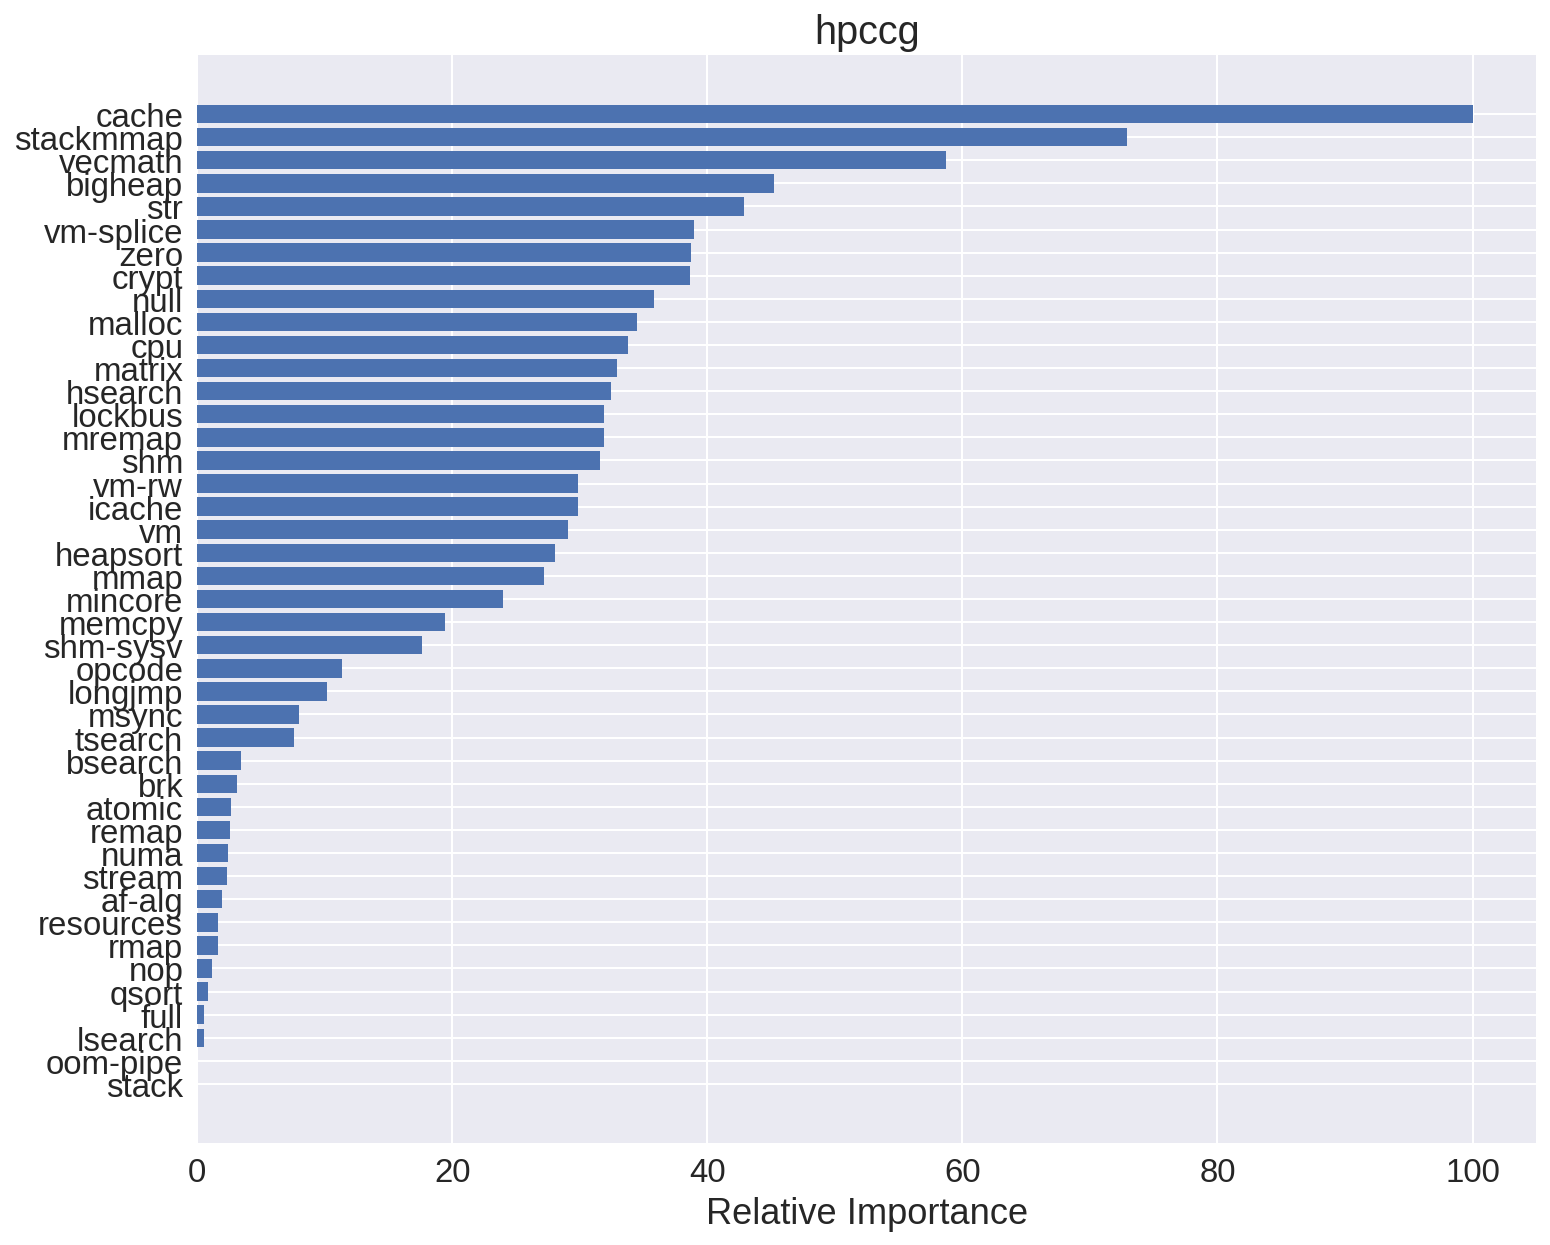

In [24]:
sns.set(rc = {'figure.figsize': (12.0, 10.0)}, font_scale=1.65)
plot_importance(get_features(df), stressors, ['hpccg'], 'hpccg.pdf')

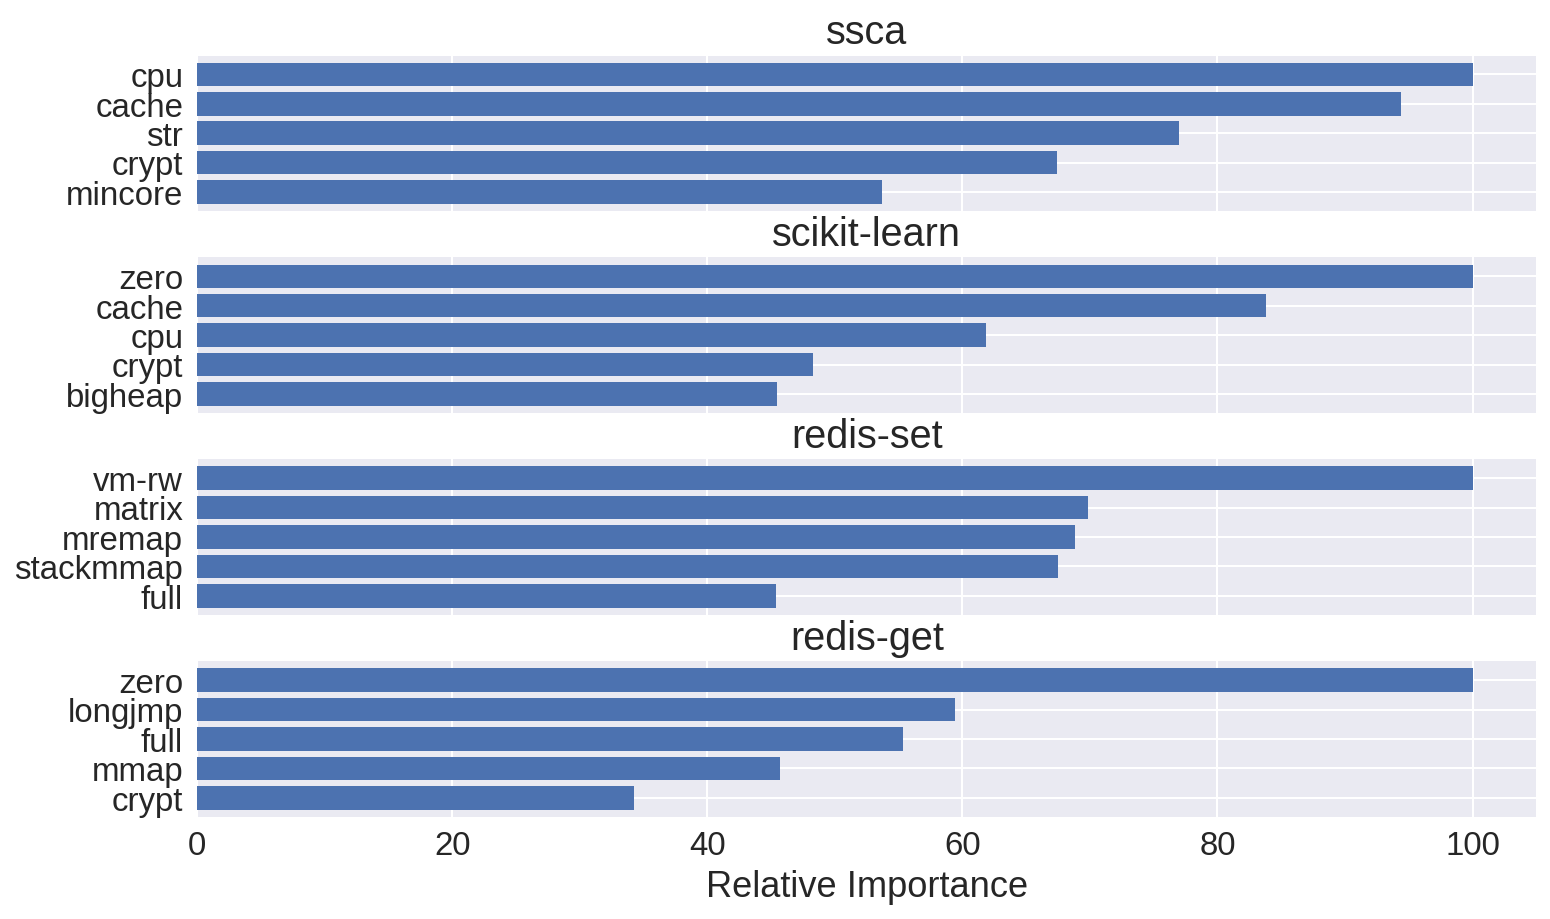

In [25]:
sns.set(rc = {'figure.figsize': (12.0, 7.0)}, font_scale=1.65)
apps = ['ssca', 'scikit-learn', 'redis-set', 'redis-get']
plot_importance(get_features(df), stressors, apps, 'four.pdf', top_n=5)

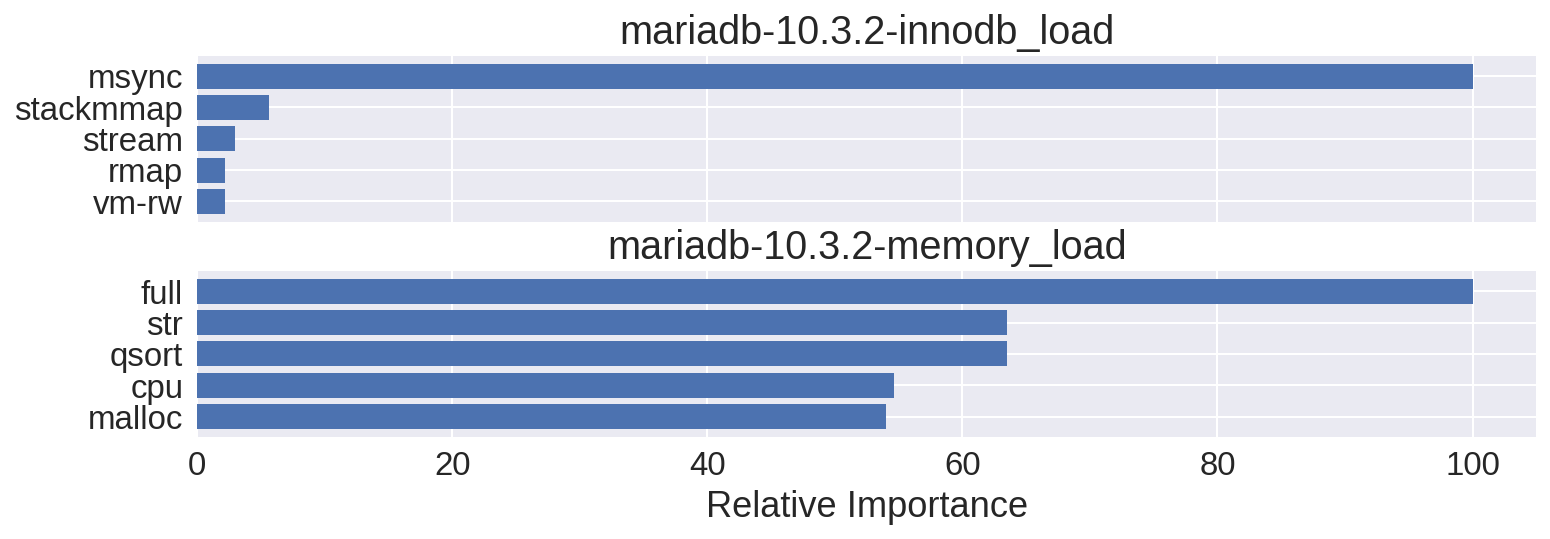

In [26]:
sns.set(rc = {'figure.figsize': (12.0, 3.5)}, font_scale=1.65)
apps = ['mariadb-10.3.2-innodb_load', 'mariadb-10.3.2-memory_load']
plot_importance(get_features(df), stressors, apps, 'mariadb-innodb-vs-memory.pdf', top_n=5)

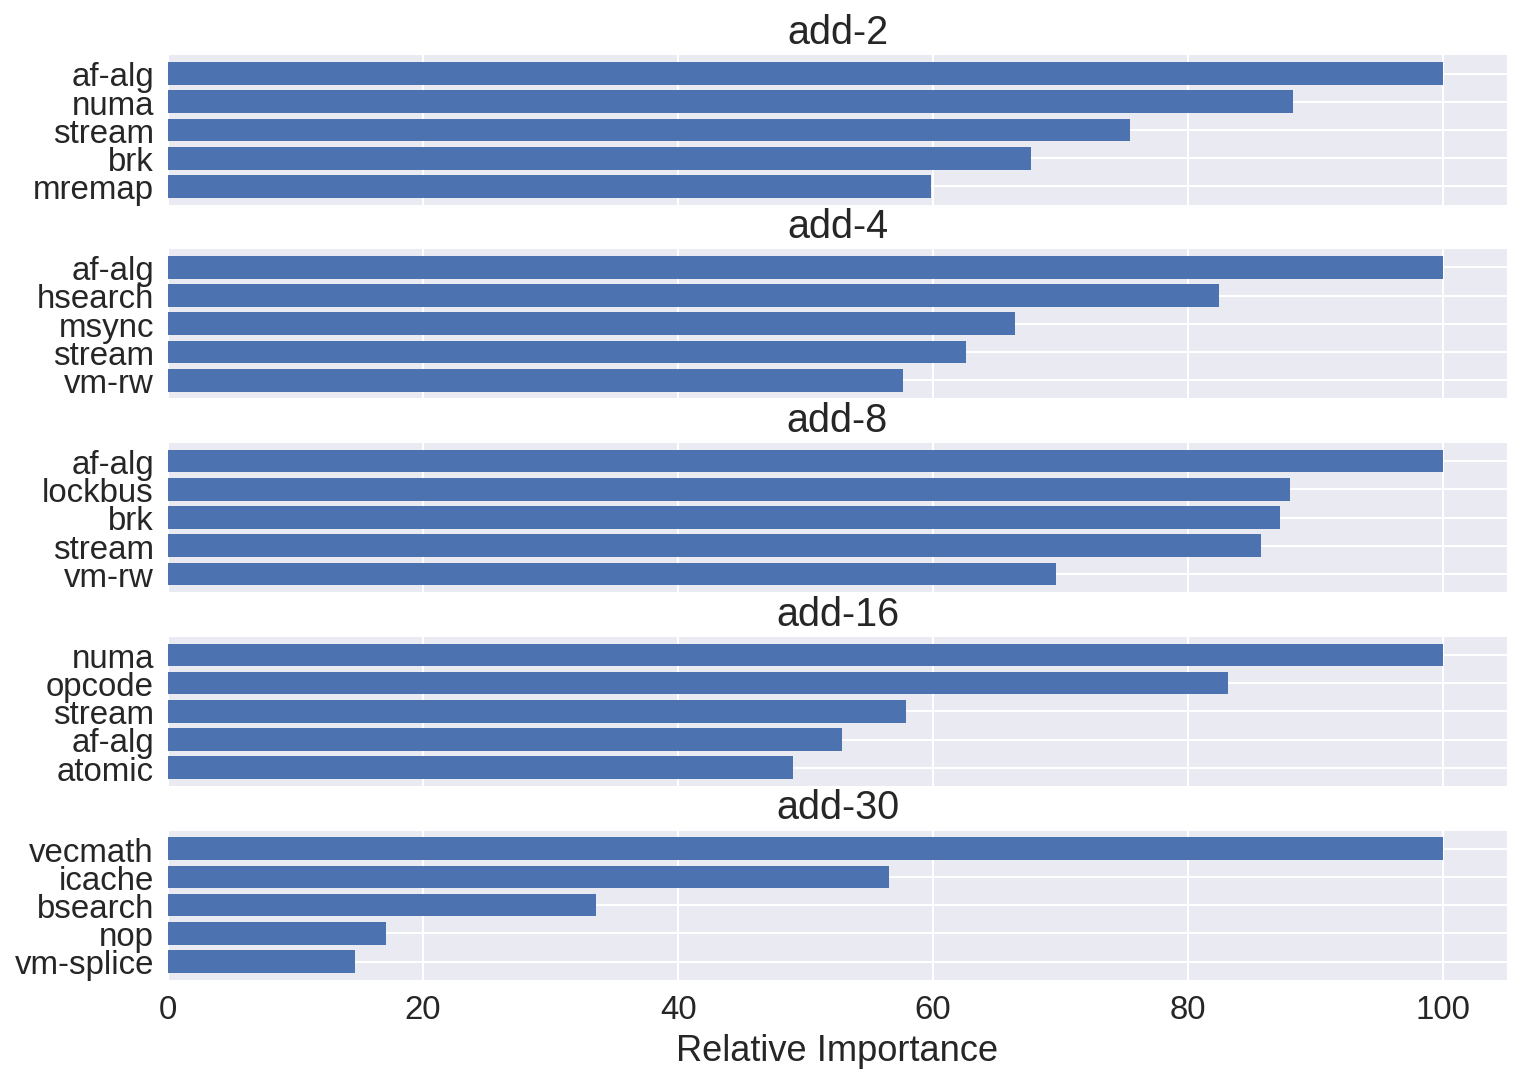

In [27]:
sns.set(rc = {'figure.figsize': (12.0, 8.5)}, font_scale=1.65)
apps = ['add-2', 'add-4', 'add-8', 'add-16', 'add-30']
plot_importance(get_features(df), stressors, apps, 'stream-nadds.pdf', top_n=5)

# underfit

In [94]:
two_machines = df.sample(2)['machine'].values
underfit_data = get_features(subdf.query('machine in @two_machines'))

show how many datapoints we have

In [95]:
len(underfit_data)

3

No we show how the correlation and IRUPs get messed up due to underfit

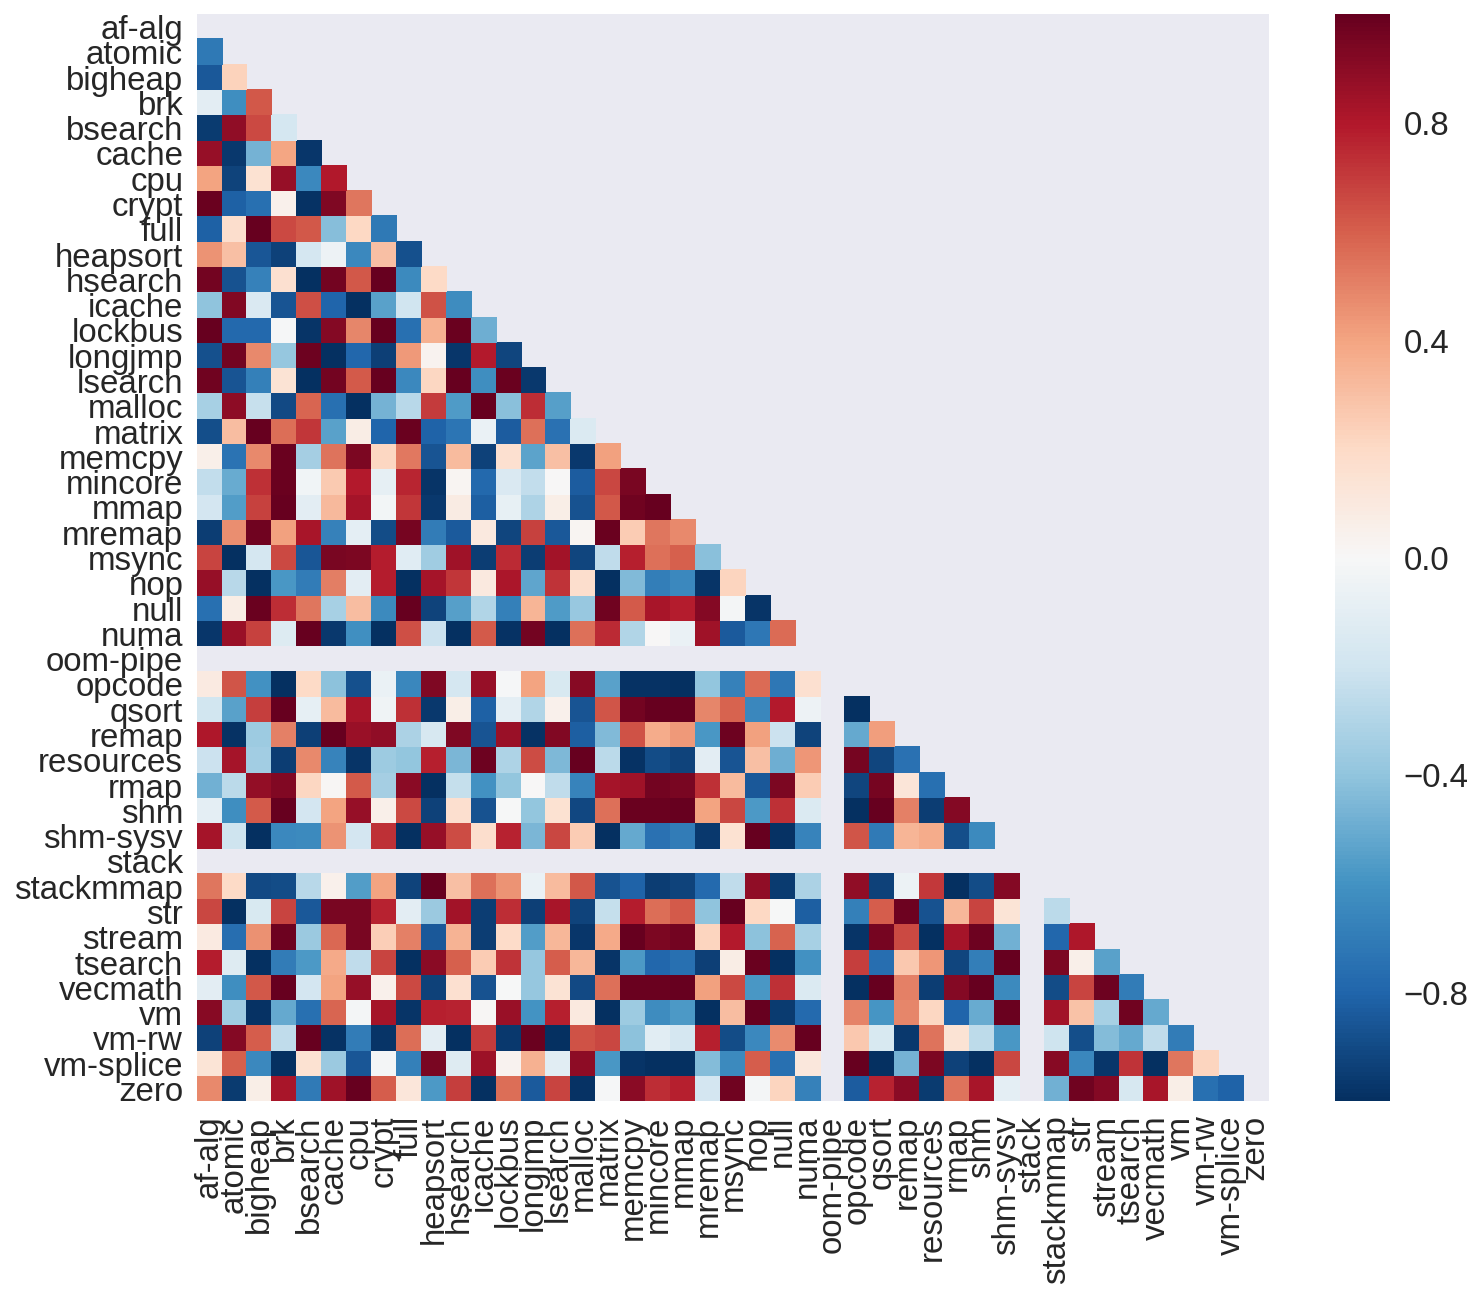

In [96]:
sns.set(rc = {'figure.figsize': (12.0, 10.0)}, font_scale=1.65)
corr_matrix = plot_corrmatrix(underfit_data[stressors])
plt.savefig('figures/corrmatrix_underfit.pdf', dpi=300, bbox_inches='tight')

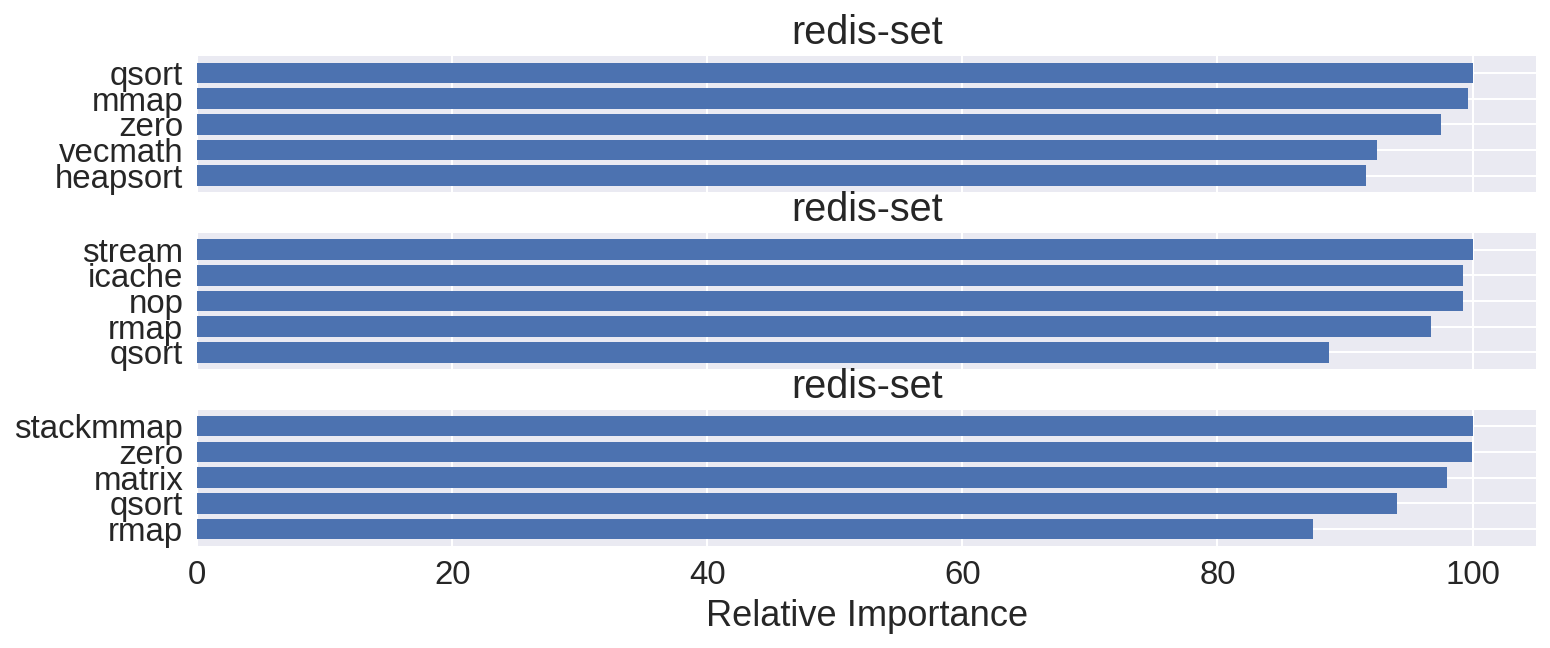

In [103]:
sns.set(rc = {'figure.figsize': (12.0, 4.5)}, font_scale=1.65)
plot_importance(underfit_data, stressors, ['redis-set', 'redis-set', 'redis-set'], 'redis-set_underfit.pdf', top_n=5)

# stream-nadds behavior

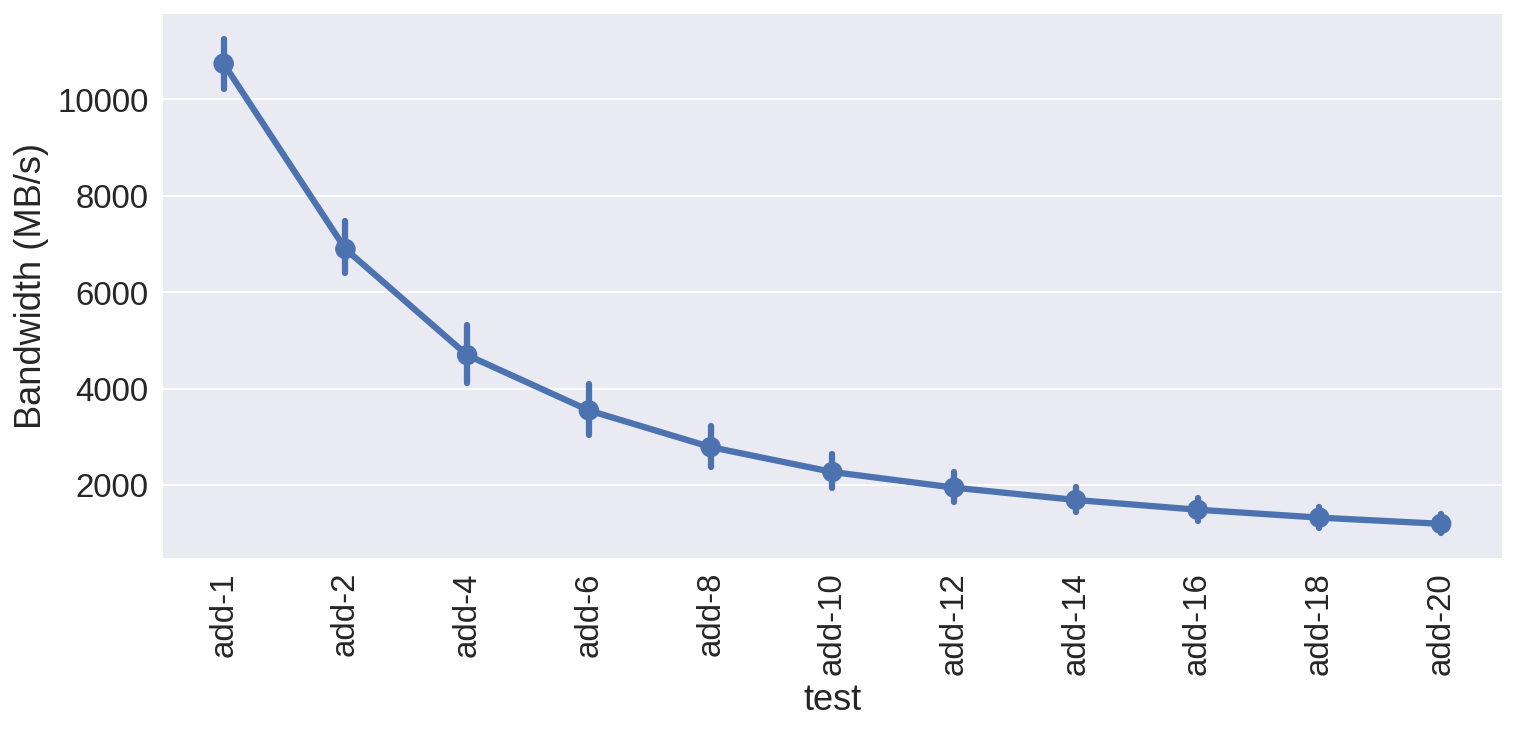

In [98]:
sns.set(rc = {'figure.figsize': (12.0, 5.0)}, font_scale=1.65)

sns.pointplot(x='test', y='result', data=df[df['test'].str.startswith('add')].query('benchmark == "stream"'), order=['add-1'] + ['add-{}'.format(i) for i in range(2,22,2)])
plt.xticks(rotation=90)
plt.ylabel('Bandwidth (MB/s)')
plt.savefig('figures/stream-nadds-behavior.pdf', dpi=300, bbox_inches='tight')

# regressions

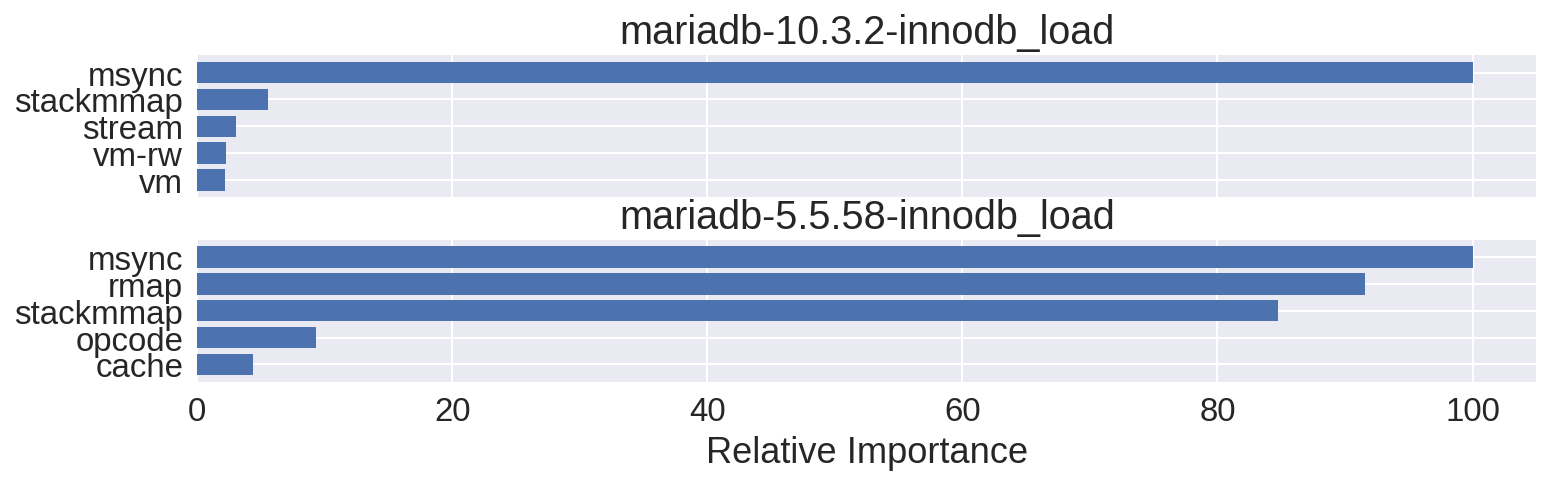

In [99]:
sns.set(rc = {'figure.figsize': (12.0, 3.0)}, font_scale=1.65)

apps = ['mariadb-10.3.2-innodb_load', 'mariadb-5.5.58-innodb_load']
plot_importance(get_features(df), stressors, apps, 'mariadb-innodb-regression.pdf', top_n=5)

## PCA

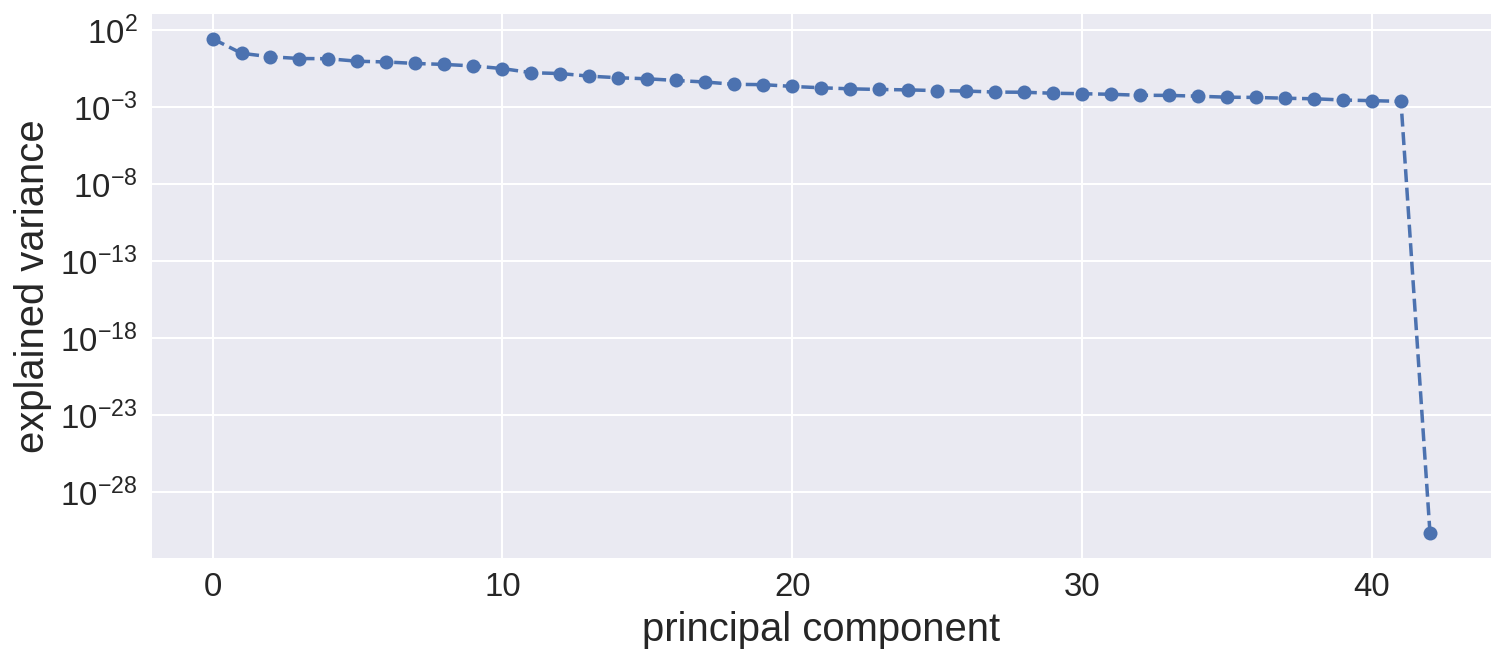

In [100]:
# taken from http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/
#            https://github.com/jotterbach/Data-Exploration-and-Numerical-Experimentation/blob/master/Data-Analytics/PCA_Pitfalls.ipynb
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(get_features(df)[stressors])

pca_stressors_norm = PCA().fit(z_data)

sns.set(rc = {'figure.figsize': (12.0, 5.0)}, font_scale=1.65)

plt.semilogy(pca_stressors_norm.explained_variance_, '--o')
plt.xlabel('principal component', fontsize = 20);
plt.ylabel('explained variance', fontsize = 20);

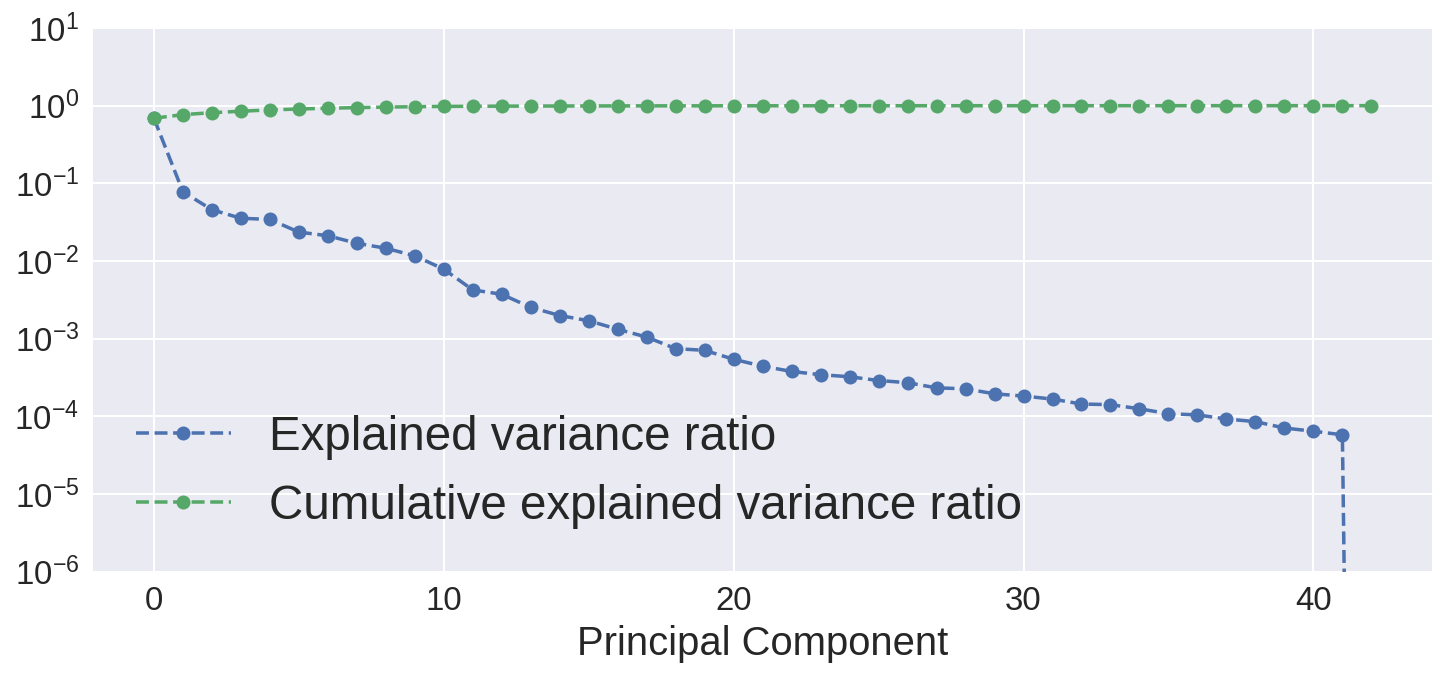

In [101]:
plt.semilogy(pca_stressors_norm.explained_variance_ratio_, '--o', label='Explained variance ratio')
plt.semilogy(pca_stressors_norm.explained_variance_ratio_.cumsum(), '--o', label='Cumulative explained variance ratio')
plt.xlabel('Principal Component', fontsize = 20)
plt.legend(loc='lower left', shadow=True, fontsize='large')
plt.ylim([.000001,10])
plt.savefig('figures/pca-var-reduction.pdf', bbox_inches='tight')